<center> <h1>PREDICIÓN DEL SUEÑO CON RANDOM FOREST</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>


###### Indice

En este jupyter notebook se lleva a cabo la construcción de un clasificador Random Forest tanto de salida binaria como multiclase para predecir tanto el estado de vigilia de los pacientes como el estado de sueño y sus distintas fases.

* **1. Cargar datos Train-Test**
  * **1.1 Preparación datos de entrada y salida**
* **2. Clasificador Random Forest Binario**
   * **2.1 Creación del modelo y selección parámetros libres**
   * **2.2 Búsqueda de parámetros con validación cruzada**
   * **2.3 Evaluación del modelo**
* **3. Clasficador Random Forest Multiclase**
   * **3.1 Creación del modelo y selección parámetros libres**
   * **3.2 Búsqueda de parámetros con validación cruzada**
   * **3.3 Evaluación del modelo**
   * **3.4 Visualización de residuos** 

IMPORTAR MÓDULOS

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statistics as stats
from sklearn.model_selection import GridSearchCV
from random import sample
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import explained_variance_score,r2_score,mean_squared_error

## 1. CARGAR DATOS TRAIN-TEST

Se cargan los datos de train y test generados en los jupyter notebooks 'Nombre de los jupyter', en los que procesan los datos y se obtienen las características que se utilizan para entrenar los clasificadores. 

En el siguiente apartado se preparan los datos para seleccionar una salida binaria o multiclase según el clasificador que se vaya a utilizar.

### 2.1 Preparación datos de entrada y salida

In [2]:
#Train
Train= pd.read_csv('Train.csv').drop(['Unnamed: 0'], axis = 1)
Test= pd.read_csv('Test.csv').drop(['Unnamed: 0'], axis = 1)

In [3]:
X_train=Train.drop(['Etiquetas', 'Etiquetas binarias','ID_P'], axis = 1) 
y_train_bin=Train['Etiquetas binarias']
y_train_multi=Train['Etiquetas']

X_test=Test.drop(['Etiquetas', 'Etiquetas binarias','ID_P'], axis = 1)
y_test_bin=Test['Etiquetas binarias']
y_test_multi=Test['Etiquetas']

## 2. CLASIFICADOR RANDOM FOREST BINARIO

En este primer clasificador, se ha utilizado el método Random Forest para clasificar la vigilia o sueño ligero del sueño profundo. Es decir, se ha construido un clasificador Random Forest con salida binaria.

### 2.1  Creación del modelo y selección parámetros libres

En primer lugar, se construye un clasificador Random Forest de salida binaria sin búsqueda de parámetros para compararlo con uno con búsqueda de parámetros y ver si realmente es eficiente esta búsqueda.

In [4]:
clf= tree.DecisionTreeClassifier()
modelo_base=clf.fit(X_train,y_train_bin)

In [5]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### 2.2 Búsqueda de parámetros con validación cruzada.

A conitnuación, se realiza la búsqueda de los mejores parámetros: máxima profundidad y minimo número de casos en cada nodo. Con ello, se busca maximizar la exactitud del modelo (accuracy).

In [6]:
max_depth=range(1,20)
min_samples_leaf=range(10,100)

param = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
tree_grid = GridSearchCV(clf, param_grid=param, scoring= 'accuracy', iid=True,cv=5, n_jobs=-1)
tree_grid.fit(X_train,y_train_bin)
best_parameters = tree_grid.best_params_

In [7]:
# Clasificador con los mejores parámetros
tree_clf=tree_grid.best_estimator_

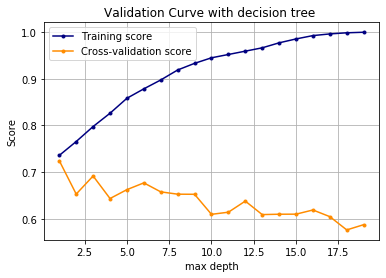

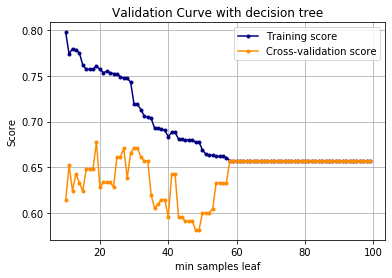

In [8]:
#max depth
train_scores, test_scores = validation_curve(clf, X_train, y_train_bin, param_name="max_depth", param_range=max_depth, cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with decision tree ")
plt.xlabel('max depth')
plt.ylabel("Score")

plt.plot(max_depth, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(max_depth, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

#min samples leaf
train_scores, test_scores = validation_curve(clf, X_train, y_train_bin, param_name="min_samples_leaf", param_range=min_samples_leaf,cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel('min samples leaf')
plt.ylabel("Score")

plt.plot(min_samples_leaf, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(min_samples_leaf, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [9]:
print('Los parámetros seleccionados por la función GridSearch son:',best_parameters)

Los parámetros seleccionados por la función GridSearch son: {'max_depth': 1, 'min_samples_leaf': 27}


In [10]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test,y_test_bin))
print("Tasa de acierto con la busqueda de parámetros:",tree_clf.score(X_test,y_test_bin))

#Mejora
print('Mejora  del {:0.2f}%.'.format( 100 * (tree_clf.score(X_test,y_test_bin) - modelo_base.score(X_test,y_test_bin)) / modelo_base.score(X_test,y_test_bin)))

Tasa de acierto del modelo base: 0.57
Tasa de acierto con la busqueda de parámetros: 0.56
Mejora  del -1.75%.


### 2.3 Evaluación del modelo

In [11]:
predict = tree_clf.predict(X_test)

acc_test= tree_clf.score(X_test, y_test_bin).round(4)
acc_train= tree_clf.score(X_train, y_train_bin).round(4)
print('La exactitud para el modelo de árboles de decisión en el conjunto de TEST es:', acc_test,'\n')
print('La exactitud para el modelo de árboles de decisión en el conjunto de TRAIN es:', acc_train,'\n')

print("Confusion Matrix")
print(confusion_matrix(y_test_bin, predict),'\n')
print("================Classification Report=================")
print(classification_report(y_test_bin, predict))

La exactitud para el modelo de árboles de decisión en el conjunto de TEST es: 0.56 

La exactitud para el modelo de árboles de decisión en el conjunto de TRAIN es: 0.7333 

Confusion Matrix
[[ 1 32]
 [12 55]] 

================Classification Report=================
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        33
         1.0       0.63      0.82      0.71        67

    accuracy                           0.56       100
   macro avg       0.35      0.43      0.38       100
weighted avg       0.45      0.56      0.49       100



In [12]:
matriz_confusion=pd.crosstab(y_test_bin,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [13]:
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,1,32
1.0,12,55


## 3. CLASIFICADOR RANDOM FOREST MULTICLASE

Este segundo clasificador Random Forest tiene una salida multiclase y clasifica tanto el estado de vigilia como las distintas etapas de sueño ligero y profundo.

### 3.1  Creación del modelo y selección parámetros libres

En primer lugar, se construye un clasificador Random Forest de salida multiclase sin búsqueda de parámetros para compararlo con uno con búsqueda de parámetros y ver si realmente es eficiente esta búsqueda.

In [14]:
clf= tree.DecisionTreeClassifier()
modelo_base=clf.fit(X_train,y_train_multi)

In [15]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### 3.2  Búsqueda de parámetros con validación cruzada.

A conitnuación, se realiza la búsqueda de los mejores parámetros: máxima profundidad y minimo número de casos en cada nodo. Con ello, se busca maximizar la exactitud del modelo (accuracy).

In [16]:
max_depth=range(1,20)
min_samples_leaf=range(10,100)

param = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
tree_grid = GridSearchCV(clf, param_grid=param, scoring= 'accuracy', iid=True,cv=5, n_jobs=-1)
tree_grid.fit(X_train,y_train_multi)
best_parameters = tree_grid.best_params_

/Applications/anaconda3/envs/cuarto/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [17]:
# Clasificador con los mejores parámetros
tree_clf=tree_grid.best_estimator_

/Applications/anaconda3/envs/cuarto/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


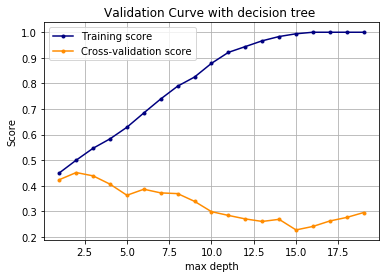

/Applications/anaconda3/envs/cuarto/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


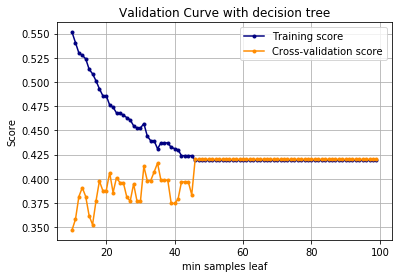

In [18]:
#max depth
train_scores, test_scores = validation_curve(clf, X_train, y_train_multi, param_name="max_depth", param_range=max_depth, cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with decision tree ")
plt.xlabel('max depth')
plt.ylabel("Score")

plt.plot(max_depth, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(max_depth, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

#min samples leaf
train_scores, test_scores = validation_curve(clf, X_train, y_train_multi, param_name="min_samples_leaf", param_range=min_samples_leaf,cv=5, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel('min samples leaf')
plt.ylabel("Score")

plt.plot(min_samples_leaf, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(min_samples_leaf, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [19]:
print('El par de parámetros estimados por GridSearch que máximiza la accuracy es:',best_parameters)

El par de parámetros estimados por GridSearch que máximiza la accuracy es: {'max_depth': 2, 'min_samples_leaf': 13}


In [20]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test,y_test_multi))
print("Tasa de acierto con la busqueda de parámetros:",tree_clf.score(X_test,y_test_multi))

#Mejora
print('Mejora  del {:0.2f}%.'.format( 100 * (tree_clf.score(X_test,y_test_multi) - modelo_base.score(X_test,y_test_multi)) / modelo_base.score(X_test,y_test_multi)))

Tasa de acierto del modelo base: 0.24
Tasa de acierto con la busqueda de parámetros: 0.3
Mejora  del 25.00%.


### 3.3 Evaluación del modelo

In [21]:
predict = tree_clf.predict(X_test)

acc_test= tree_clf.score(X_test, y_test_multi).round(4)
acc_train= tree_clf.score(X_train, y_train_multi).round(4)
print('La exactitud para el modelo de árboles de decisión en el conjunto de TEST es:', acc_test,'\n')
print('La exactitud para el modelo de árboles de decisión en el conjunto de TRAIN es:', acc_train,'\n')

print("Confusion Matrix")
print(confusion_matrix(y_test_multi, predict),'\n')
print("================Classification Report=================")
print(classification_report(y_test_multi, predict))

La exactitud para el modelo de árboles de decisión en el conjunto de TEST es: 0.3 

La exactitud para el modelo de árboles de decisión en el conjunto de TRAIN es: 0.4952 

Confusion Matrix
[[ 0  0  0  6  0  0  0]
 [ 0  0  0  9  3  0  0]
 [ 0  0  0  2  3  0  1]
 [ 2  0  0 28 11  0  5]
 [ 1  0  0  7  1  0  3]
 [ 0  0  0  1  2  0  0]
 [ 0  0  0 12  2  0  1]] 

================Classification Report=================
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         6
         0.0       0.00      0.00      0.00        12
         1.0       0.00      0.00      0.00         6
         2.0       0.43      0.61      0.50        46
         3.0       0.05      0.08      0.06        12
         4.0       0.00      0.00      0.00         3
         5.0       0.10      0.07      0.08        15

    accuracy                           0.30       100
   macro avg       0.08      0.11      0.09       100
weighted avg       0.22      0.30      0.25

/Applications/anaconda3/envs/cuarto/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
matriz_confusion=pd.crosstab(y_test_multi,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [23]:
matriz_confusion

Resultado del clasificador,-1.0,2.0,3.0,5.0
Clase predicha,,,,
-1.0,0,6,0,0
0.0,0,9,3,0
1.0,0,2,3,1
2.0,2,28,11,5
3.0,1,7,1,3
4.0,0,1,2,0
5.0,0,12,2,1


### 3.4 Visualización de residuos

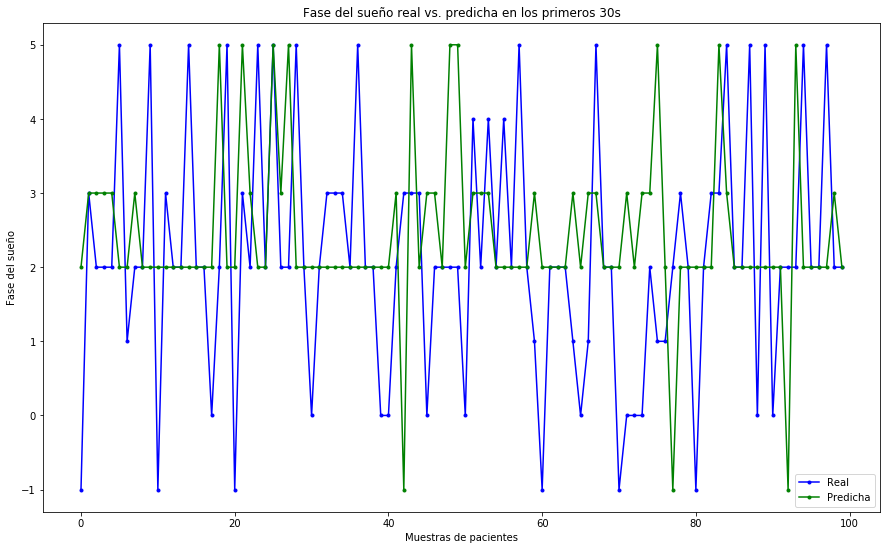

In [24]:
pacientes = len(y_test_multi)
t = np.arange(0,pacientes)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_multi,color='blue', marker='.',label='Real')
plt.plot(t,predict,color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.xlabel('Muestras de pacientes')
plt.ylabel('Fase del sueño')
#plt.yticks([-1,0])
#plt.xlim([0,10])
plt.legend()

* Hemos estimado ambos parámetros porque va más rápido que svm
* Peores prestaciones que SVM
* No se detectan todas las clases --> necesitamos entrenar con mas datos 
* Baja accuracy en multiclase